# Back to the Future : Time Travelling through Wikispeedia

## Part 0 : Preprocessing of data

#### Setting the environment 
Please check SETUP.md and pip_requirements.txt before running this notebook.

In [1]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import os as os
import sys
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

sys.path.append('../') 
sys.path.append('../data/') 
from src.scripts.loading_data import *
from src.utils.data_utils import *
from src.scripts.plotting import *

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM


np.random.seed(42)

Some definitions:
- source or start article: the initial point of a game
- target article: the final point that players are looking for.
- path: all the articles visited by the player during his/her game, including the source and target articles (if the latter is found)


## Part 1 : Defining the best moment to play Wikispeedia

### 1.0) Introduction
The start point of our journey is situated in the past, in 2007. We investigate possible reasons of failure at the Wikispeedia game on articles from 2007. For this purpose, we use the dataset furnished [1][2].


### 1.1) Exploring categories
The categories of the articles are given in the `categories.tsv` file.

#### 1.1.1) Cleaning the categories

We load the cartegories and articles. 

In [2]:
articles2007, links2007 = loading_articles_links('2007')

categories = loading_cleaned_categories()
print(f'Shape of categories df: {categories.shape}, number of unique articles in categories.tsv: {categories.index.unique().shape}, number of articles in articles.tsv: {articles2007.article_2007.unique().shape}')

Shape of categories df: (5204, 3), number of unique articles in categories.tsv: (5204,), number of articles in articles.tsv: (4604,)


There are more rows in categories than the number of articles. Some articles have more than 1 category! In addition, there are less unique appearance of articles than the total number of articles in `articles.tsv`! We want to fix that. First let's find the 6 articles missing in `categories.tsv`.

In [3]:
articles_not_in_categories = art_not_in_cat(articles2007, categories, 'article_2007')
articles_not_in_categories

array(['Directdebit', 'Donation', 'Friend_Directdebit', 'Pikachu',
       'Sponsorship_Directdebit', 'Wowpurchase'], dtype=object)

We got them. Let's keep them here for later, it might be useful. Now let's deal with articles having several categories. First, let's find them.

In [4]:
categories.article.value_counts().value_counts()

count
1    4000
2     590
3       8
Name: count, dtype: int64

4000 articles have only 1 category, 590 have 2 categories and 8 of them have 3 categories.

In [5]:
categories_duplicated = categories.loc[categories.article.duplicated(keep=False)]
categories_duplicated.sample(20)

,article,category,main_category
425,Attila_the_Hun,"[People, Military_People]",People
764,Brazil,"[Geography, Central_and_South_American_Geograp...",Geography
3077,Medieval_literature,"[Language_and_literature, Literature_types]",Language_and_literature
2629,Kazakhstan,"[Geography, Geography_of_Asia, Asian_Countries]",Geography
1117,Common_Pheasant,"[Science, Biology, Birds]",Science
3076,Medieval_literature,"[History, British_History, British_History_150...",History
588,Beekeeping,"[Everyday_life, Food_and_agriculture]",Everyday_life
1221,Crown_Jewels_of_the_United_Kingdom,"[Citizenship, Politics_and_government]",Citizenship
1494,Edwin_of_Northumbria,"[People, Historical_figures]",People
2432,Ireland,[Countries],Countries


We notice that some articles have the same main category but the subcategories are different. Let's focus on the main category and get rid off the other subcategories. We keep delete one the duplicated main category for every concerned article. 

In [6]:
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category
177,Al_Jazeera,"[Citizenship, Media]",Citizenship
178,Al_Jazeera,"[Citizenship, Politics_and_government]",Citizenship
205,Alfred_the_Great,"[People, Military_People]",People
206,Alfred_the_Great,"[People, Monarchs_of_Great_Britain]",People
297,Animation,"[Everyday_life, Computer_and_Video_games]",Everyday_life
...,...,...,...
5046,Whipworm,"[Science, Biology, Organisms]",Science
5051,White_cliffs_of_Dover,"[Geography, Geography_of_Great_Britain]",Geography
5052,White_cliffs_of_Dover,"[Geography, Geology_and_geophysics]",Geography
5068,William_Ewart_Gladstone,"[People, Historical_figures]",People


In [7]:
categories = categories.drop(index=categories.loc[categories[['article', 'main_category']].duplicated()].index)
categories

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
4,%C3%89douard_Manet,"[People, Artists]",People
...,...,...,...
5199,Zirconium,"[Science, Chemistry, Chemical_elements]",Science
5200,Zoroaster,"[People, Religious_figures_and_leaders]",People
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography
5202,Zuid-Gelders,"[Language_and_literature, Languages]",Language_and_literature


In [8]:
# let's check if this problem is solved, i.e. this command return an empty df
categories.loc[categories[['article', 'main_category']].duplicated(keep=False)]

,article,category,main_category


In [9]:
# update the df containing only duplicated articles. We have deleted 90 useless rows. 
categories_duplicated = categories.loc[categories.article.duplicated(keep=False)]
categories_duplicated

,article,category,main_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[History, British_History, British_History_150...",History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,"[People, Historical_figures]",People
2,%C3%85land,[Countries],Countries
3,%C3%85land,"[Geography, European_Geography, European_Count...",Geography
5,%C3%89ire,[Countries],Countries
...,...,...,...
5193,Zimbabwe,[Countries],Countries
5197,Zionism,"[People, Political_People]",People
5198,Zionism,"[Religion, Religious_movements_traditions_and_...",Religion
5201,Zuid-Gelders,"[Geography, European_Geography]",Geography


It looks better, but we still have 1013 rows to sort out. From now on, we will do purely arbitrary choices to keep only one main category.
You can find the logical reasoning and examples of paths concerned in `categories_partial_ordering.md`. Using this partial ordering, we can kick out the duplicated articles we do not want.

In [10]:

relationships = [('History', 'People'), ('Religion', 'People'), ('Language_and_literature', 'People'),
 ('Science', 'People'), ('Religion', 'History'), ('Countries', 'Geography'), ('Language_and_literature', 'Geography'), 
 ('Language_and_literature', 'Design_and_Technology'), ('Language_and_literature', 'History'), ('Science', 'Everyday_life'), 
 ('Science', 'Design_and_Technology'), ('Geography', 'Design_and_Technology'), ('Design_and_Technology', 'History'), 
 ('Mathematics', 'Everyday_life'), ('Everyday_life', 'People'), ('Everyday_life', 'History'), ('Geography', 'History'),
 ('Geography', 'Citizenship'), ('Design_and_Technology', 'Citizenship'), ('Design_and_Technology', 'Everyday_life'),
 ('Science', 'Citizenship'), ('IT', 'Business_Studies'), ('Business_Studies', 'Geography'), ('Business_Studies', 'People'),
 ('Everyday_life', 'Citizenship'), ('Business_Studies', 'Everyday_life'), ('Everyday_life', 'People'), ('IT', 'Science'),
 ('Geography', 'Everyday_life'), ('Science', 'Geography'), ('Business_Studies', 'History'), ('History', 'Citizenship'),
 ('Science', 'History'), ('Science', 'Business_Studies'), ('Art', 'Everyday_life'), ('Art', 'Business_Studies'),
 ('Art', 'Design_and_Technology'), ('Music', 'History'), ('Religion', 'Citizenship'), ('IT', 'Design_and_Technology'),
 ('IT', 'Citizenship'), ('Business_Studies', 'Citizenship'), ('Art', 'History'), ('IT', 'History'), 
 ('Science', 'Religion'), ('Language_and_literature', 'Art'), ('Design_and_Technology', 'People')]

categories, categories_duplicated = delete_duplicates_cat(categories, relationships)

print(f'Number of unique article names in categories: {categories.article.unique().size}, number of rows: {categories.article.size}.')

categories = categories.set_index('article') # easier for the following

display(categories_duplicated) # is empty, as expected

Number of unique article names in categories: 4598, number of rows: 4598.


,article,category,main_category


In [11]:
plot_cat_pie_chart(categories)

#### 1.1.2) Links and categories

Now each article has only one category assigned. We can thus work with the categories. First, let's analyse where do the links present in an article of a given category send the player: in the same category, or in another one?


In [12]:
# have to check that the articles present in the links.tsv are in categories.tsv

# retrieve all the article names present in links.tsv
articles_names_from_links = list(links2007.linkSource.unique()) + list(links2007.linkTarget.unique())

# keep 1 occurence per name only
articles_names_from_links = pd.DataFrame.from_dict({'article': list(set(articles_names_from_links))})

# find the articles that are not in categories.tsv
articles_to_drop = art_not_in_cat(articles_names_from_links, categories, 'article', index=True)
print(f'{len(articles_to_drop)} articles have to be dropped: {articles_to_drop}')

# We drop them because we can not associate a category to them:
links2007 = links2007.loc[~links2007.linkSource.isin(articles_to_drop) & ~links2007.linkTarget.isin(articles_to_drop)]

# We add columns containing the categories of the source and target articles
links2007['catSource'] = links2007['linkSource'].map(lambda x: categories.main_category.loc[x])
links2007['catTarget'] = links2007['linkTarget'].map(lambda x: categories.main_category.loc[x])

links2007

4 articles have to be dropped: ['Sponsorship_Directdebit' 'Directdebit' 'Friend_Directdebit' 'Pikachu']


,linkSource,linkTarget,catSource,catTarget
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,History,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,History,People
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,History,History
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,History,History
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,History,Countries
...,...,...,...,...
119877,Zulu,South_Africa,Geography,Countries
119878,Zulu,Swaziland,Geography,Countries
119879,Zulu,United_Kingdom,Geography,Countries
119880,Zulu,Zambia,Geography,Countries


Let's create a heatmap to represent from which to which categories the links go.

In [13]:
distrib_links, num_links = get_heatmap_data(links2007, categories, 'links')


cats = sorted(categories.main_category.unique())
plot_heatmap(distrib_links.reshape(15, 15), cats, num_links, 'links', gamma=0.45)

First, the diagonal, i.e. links staying in the same category has bigger values compared to the lines or columns in general. Then, we can observe that the brighter columns are the ones from science, geography and countries. For science and geography, it makes sense as these are the most represented categories as we have seen previously. On the other hand, it seems very easy to reach articles about countries: there are more than twice of links pointing to countries as links going out from countries. It seems logical as for many concepts, the place of invention discovery or birth is mentioned, including the country. Science articles are the ones linking out the least to other categories, with only 41% of links going elsewhere than in science articles.

#### 1.1.3) Category of the source and target articles
Let's analyse the category of the source and target articles between the finished and unfinished paths to determine if it has an influence on the game outcomes. We load the paths and remove the ones that start/finish on articles with no category. We define the length of a path as the number of clicks of the player. We also remove the paths of length 0: in the case of a finished path, it means that the start and target articles were identical. In the case of unfinished paths, it means that the player did not click on any link. Both cases are uninteresting because the players did not really play.

In [14]:
path_finished, path_unfinished = loading_paths()

# let's check again that all the article names of interest are present in categories.tsv
articles_not_in_categories = list(articles_not_in_categories) + list(art_not_in_cat(path_finished, categories, 'start', True))

articles_not_in_categories += list(art_not_in_cat(path_finished, categories, 'end', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'start', True))
articles_not_in_categories += list(art_not_in_cat(path_unfinished, categories, 'target', True))

articles_not_in_categories = list(set(articles_not_in_categories))
print(f'{len(articles_not_in_categories)} articles do not appear in categories.tsv: {np.array(articles_not_in_categories)}')

# let's remove these paths and add new columns with categories and path length
# path_(un)finished_cleaned correspond to path_(un)finished without the paths of length 0
path_finished, path_unfinished, path_finished_cleaned, path_unfinished_cleaned = cleaned_paths(path_finished, path_unfinished, categories, articles_not_in_categories)

31 articles do not appear in categories.tsv: ['Rat' 'Black_ops_2' 'C++' 'Donation' 'Georgia' 'Wowpurchase' '_Zebra'
 'Netbook' 'Podcast' 'Fats' 'Friend_Directdebit' 'Test' 'Charlottes_web'
 'English' 'Western_Australia' 'Christmas' 'Kashmir' 'Usa' 'Macedonia'
 'Adolph_Hitler' 'Long_peper' 'Sponsorship_Directdebit' 'Bogota' 'Great'
 'Pikachu' 'The_Rock' 'Mustard' 'Sportacus' 'The' 'Directdebit' 'Rss']
After cleaning articles not in categories.tsv
Initial number of rows in path finished: 51318, current number of rows: 51249, percentage of loss: 0.13%
Initial number of rows in path unfinished: 24875, current number of rows: 24802, percentage of loss: 0.29%
After cleaning articles not in categories.tsv + remove paths with length 0
Initial number of rows in path finished: 51318, current number of rows: 51238, percentage of loss: 0.16%
Initial number of rows in path unfinished: 24875, current number of rows: 19607, percentage of loss: 21.18%


We are loosing one fifth of the unfinished paths but as stated previously, the discarded paths are not providing any information. For the finished paths, the loss is negligible.

Let's create heat maps to vizualise in which categories the game starts and ends

In [15]:
distrib_f, tot_links_f = get_heatmap_data(path_finished_cleaned, categories, 'f')
distrib_unf, tot_links_unf = get_heatmap_data(path_unfinished_cleaned, categories, 'unf')


global_min = min(np.min(distrib_links), np.min(distrib_f), np.min(distrib_unf)) * 100
global_max = max(np.max(distrib_links), np.max(distrib_f), np.max(distrib_unf)) * 100

all_to_cat_f, cat_to_all_f = plot_heatmap(distrib_f.reshape(15, 15), cats, tot_links_f, 'f', vmin=global_min, vmax=global_max, gamma=0.45, stats=True)
all_to_cat_unf, cat_to_all_unf = plot_heatmap(distrib_unf.reshape(15, 15), cats, tot_links_unf, 'unf', vmin=global_min, vmax=global_max, gamma=0.45, stats=True)
# plot_heatmap(distrib_unf_start2end.reshape(15, 15), cats, tot_links_unf, 'unf_start', vmin=global_min, vmax=global_max, gamma=0.45)
# plot_heatmap(distrib_unf_end2target.reshape(15, 15), cats, tot_links_unf, 'unf_target', vmin=global_min, vmax=global_max, gamma=0.45)

To simplify the interpretation, we print show the statistics by categories, i.e. the number of games starting of targeting a given category.

In [16]:
# all_to_cat: proportion of games targeting the cat
# cat_to_all: proportion of games starting from the cat


stats_by_cat = pd.DataFrame([all_to_cat_f, all_to_cat_unf, cat_to_all_f, cat_to_all_unf], index=['all_to_cat_f', 'all_to_cat_unf', 'cat_to_all_f', 'cat_to_all_unf']).transpose()
stats_by_cat['percentage_diff_all_to_cat'] = (stats_by_cat['all_to_cat_f']-stats_by_cat['all_to_cat_unf'])/stats_by_cat['all_to_cat_f']*100
stats_by_cat['percentage_diff_cat_to_all'] = (stats_by_cat['cat_to_all_f']-stats_by_cat['cat_to_all_unf'])/stats_by_cat['cat_to_all_f']*100
stats_by_cat['ratio_all_to_cat'] = stats_by_cat['all_to_cat_f']/stats_by_cat['all_to_cat_unf']
stats_by_cat['ratio_cat_to_all'] = stats_by_cat['cat_to_all_f']/stats_by_cat['cat_to_all_unf']

stats_by_cat


,all_to_cat_f,all_to_cat_unf,cat_to_all_f,cat_to_all_unf,percentage_diff_all_to_cat,percentage_diff_cat_to_all,ratio_all_to_cat,ratio_cat_to_all
Art,0.638198,0.668129,0.776767,0.821135,-4.689847,-5.711887,0.955202,0.945967
Business_Studies,1.407159,1.820778,1.633553,1.514765,-29.393950,7.271761,0.772834,1.078420
Citizenship,3.458371,4.069975,3.548148,3.289641,-17.684751,7.285672,0.849728,1.078582
Countries,8.103361,2.065589,5.632538,5.166522,74.509480,8.273644,3.923027,1.090199
Design_and_Technology,4.957258,8.083848,4.853819,7.997144,-63.070938,-64.759814,0.613230,0.606944
Everyday_life,6.514696,10.766563,9.522230,8.721375,-65.265774,8.410368,0.605086,1.091827
Geography,16.950310,10.567654,14.555603,13.270771,37.655098,8.827065,1.603980,1.096817
History,9.582732,9.603713,7.742301,7.206610,-0.218950,6.919013,0.997815,1.074333
IT,2.621102,2.560310,2.343963,2.172693,2.319309,7.306856,1.023744,1.078828
Language_and_literature,2.500098,3.799663,4.916273,6.803693,-51.980603,-38.391266,0.657979,0.722589


In [17]:
## plots for the datastory (some visual adjustements):
# plot_heatmap_datastory(distrib_f.reshape(15, 15), cats, tot_links_f, 'f', vmin=global_min, vmax=global_max, gamma=0.45)
# plot_heatmap_datastory(distrib_unf.reshape(15, 15), cats, tot_links_unf, 'unf', vmin=global_min, vmax=global_max, gamma=0.45)


We can see differences between the proportions. But are they significiant?

We do a chi2 contingency test. Our null hypothesis is that the distributions are identical.


In [18]:
print(f'Chi2 contingency test (pvalue, statistic): {chi2_contingency_test(distrib_f*tot_links_f, distrib_unf*tot_links_unf)}')


Chi2 contingency test (pvalue, statistic): (0.0, 2951.9510869360092)


The pvalue is 0. We can thus reject the null hypothesis and say that the distributions are different.

We nevertheless have to take the results with precaution at the moment, because of one category combination that has 0 count and $\chi^2$-test might fail in this case. There are also combinations with less than 5 occurences but it represents less than 20% of the combinations so it is not a problem [3]. 

In [19]:
print(f'finished paths:')
print(f'- number of categories combination with less than 5 occurences = {len(np.where(distrib_f*tot_links_f<=5)[0])}')
print(f'- number of categories combination with 0 occurence = {len(np.where(distrib_f*tot_links_f<=0)[0])}\n')

print(f'unfinished paths:')
print(f'- number of categories combination with less than 5 occurences = {len(np.where(distrib_unf*tot_links_unf<=5)[0])}')
print(f'- number of categories combination with 0 occurence = {len(np.where(distrib_unf*tot_links_unf<=0)[0])}')

finished paths:
- number of categories combination with less than 5 occurences = 7
- number of categories combination with 0 occurence = 1

unfinished paths:
- number of categories combination with less than 5 occurences = 29
- number of categories combination with 0 occurence = 1


We can do the same test with the more general statistics.

In [20]:
print(chi2_contingency_test(np.array(list(all_to_cat_f.values()))*tot_links_f, np.array(list(all_to_cat_unf.values()))*tot_links_unf))
print(chi2_contingency_test(np.array(list(cat_to_all_f.values()))*tot_links_f, np.array(list(cat_to_all_unf.values()))*tot_links_unf))

(0.0, 207550.4469636167)
(0.0, 39993.033636189735)


They give the same pvalue and they do not present the same concerns regarding the validity of the $\chi^2$ test. We can thus conclude that categories have thus a influence in player's success.

### 1.2) Other factors

#### 1.2.1) Shortest path

One can assume that the shorter the shortest path, the more likely it is to find a path, because navigating between the two articles requires less clicks.

The shortest path between two articles is given by the minimum number of links you must click to reach the desired article.



In [21]:
# we prepare a data frame containing all the games with a length greater than 0
all_games = prepare_all_games(path_finished, path_unfinished, categories, links2007, articles2007)
all_games.sample(10)

Before removing path of length 0: win percentage=0.6738901746265517, number of games=76048
After removing path of length 0 : win percentage=0.7232573896840857, number of games=70842
Percentage of games discarded: 6.85%


,start,target,path,finished?,length,game,links_to_target,shortest_path,catSource,catTarget
58418,Quantum_chemistry,Allegory_in_the_Middle_Ages,"[Quantum_chemistry, Chemistry, Alchemy, Bible]",0,3,"Quantum_chemistry, Allegory_in_the_Middle_Ages",2,4,Science,Religion
44891,Perfect_number,Uranium,"[Perfect_number, Ancient_Greece, University, A...",1,7,"Perfect_number, Uranium",69,4,Mathematics,Science
2225,Bird,Adolf_Hitler,"[Bird, Latin, Rome, Nazi_Germany, Adolf_Hitler]",1,4,"Bird, Adolf_Hitler",109,3,Science,People
24552,Scientific_classification,Abuja,"[Scientific_classification, Aristotle, Geograp...",1,6,"Scientific_classification, Abuja",8,3,Science,Geography
29933,Curium,Vegetable,"[Curium, Californium, Water, Agriculture, Vege...",1,4,"Curium, Vegetable",43,4,Science,Science
35007,BAE_Systems,Afghanistan,"[BAE_Systems, Saudi_Arabia, Afghanistan]",1,2,"BAE_Systems, Afghanistan",143,2,Business_Studies,Countries
29117,Dance,Orion_Nebula,"[Dance, Culture, Nature, Universe, Galaxy, Sol...",1,21,"Dance, Orion_Nebula",5,3,Everyday_life,Science
70921,Celtic_Park,Tofu,"[Celtic_Park, Scotland, China]",0,2,"Celtic_Park, Tofu",4,4,Everyday_life,Everyday_life
2624,Calculus,Tripoli,"[Calculus, Europe, Mediterranean_Sea, Libya, T...",1,4,"Calculus, Tripoli",14,3,Mathematics,Geography
32064,Peregrine_Falcon,North_America,"[Peregrine_Falcon, Canada, North_America]",1,2,"Peregrine_Falcon, North_America",409,3,Science,Geography


In [22]:
interactive_plot_distrib_length_shortest_path(all_games)

The longer the shortest path, the fewer finished paths there are! The longest shortest path for which we have finished paths is 7, for which we have only 17 games played. There is an increase with the shortest path of the porportion of players that did not go far enough anyway to reach the target, as they stopped before even reaching the shortest path length. As we could expect, the largest success rate occurs with a shortest path of 1 and decreases while the shortest path increases, except for a shortest path of 4 that where the success rate is slightly higher than for 3. However, the results should be taken precautionously due to the very different number of games played for each shortest path.

#### 1.2.2) Number of links to target

Another parameter might be the number of links leading to the target: intuitively, the more there are the easier it is to reach the article. To investivigate this hypothesis, we plot the distribution of the number of links to the target article depending on whether the player won.

In [23]:
plot_distrib_number_links2target(all_games)

Both distribution shapes are similar, but the one from unfinished paths is shifted to the left and there is a peak at 1. We do a Welsch's t-test of independence to check if they are different. This test allows to have different variances, such as our case here. Our null hypothesis is that the two distributions are identical. We use `ttest_ind_from_stats` from scipy with alternative hypothesis that the mean for finished paths is higher. 

In [24]:
from scipy.stats import ttest_ind_from_stats


finished = all_games.loc[all_games['finished?']==1].links_to_target
unfinished = all_games.loc[all_games['finished?']==0].links_to_target
ttest_ind_from_stats(finished.mean(), finished.std(), finished.shape[0], unfinished.mean(), unfinished.std(), unfinished.shape[0], equal_var=False, alternative='greater')


Ttest_indResult(statistic=59.598906454875596, pvalue=0.0)

We can thus safely reject our null hypothesis and conclude that the two distributions are indeed different, the one for finished paths having a greater mean.

### 1.3) Logistic regression

To investigate how much each factor influence the success rate, we can train a logistic model to predict the probability of success of the players. We split the dataset in training (80% of the samples), validation (10%) and testing (10%) sets and apply one hot encoding for categorical columns, dropping one of the category to avoid multicolinearity.

In [25]:


X_cat = all_games[['shortest_path', 'links_to_target', 'catSource', 'catTarget']]
y_cat = all_games[['finished?']]
X_cat = pd.get_dummies(X_cat, columns=['catSource', 'catTarget'], drop_first=True)

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)
X_cat_valid, X_cat_test, y_cat_valid, y_cat_test = train_test_split(X_cat_test, y_cat_test, test_size=0.5, random_state=42)
print(f"# of training samples: {len(X_cat_train)} # of validation samples: {len(X_cat_valid)} # of testing samples: {len(X_cat_test)}")


# of training samples: 56673 # of validation samples: 7084 # of testing samples: 7085


In [26]:
y_cat_train.value_counts()

finished?
1            40929
0            15744
Name: count, dtype: int64

The data is highly unbalanced: 72% of the samples are win in the training set. To avoid bias because of this, we introduce weights invertionally proportional to the number of (un)finished paths.

In [27]:
# Weights

class_counts = y_cat_train.value_counts()
total_samples = len(y_cat_train)

class_weight = {0: total_samples / (2 * class_counts.loc[0].values[0]), 
                1: total_samples / (2 * class_counts.loc[1].values[0])}

print(f"\nClass weights: {class_weight}")

# Assign sample weights based on the class of each sample
weights = y_cat_train.map(lambda x: class_weight[x]).values.flatten()


Class weights: {0: 1.799828506097561, 1: 0.69233306457524}


Another possiblity that had been considered was down sampling, i.e. taking randomly a certain number of samples among finished paths to have the same number of samples as for the unfinished paths. However, this technique discards many paths, so we chose the other one.

In [28]:
# # Down sampling


# from sklearn.utils import resample, shuffle
# y_cat_train_majority = y_cat_train.loc[y_cat_train['finished?'] == 1]
# y_cat_train_minority = y_cat_train.loc[y_cat_train['finished?'] == 0]

# y_cat_train_majority_downsampled = resample(y_cat_train_majority,
#                                       replace=False,  # Without replacement
#                                       n_samples=len(y_cat_train_minority), 
#                                       random_state=42)

# y_cat_train = pd.concat([y_cat_train_minority, y_cat_train_majority_downsampled]).sort_index()

# X_cat_train = X_cat_train.loc[y_cat_train.index].sort_index()

# X_cat_train, y_cat_train = shuffle(X_cat_train, y_cat_train, random_state=42)

# print(y_cat_train_majority.size/(y_cat_train_majority.size+y_cat_train_minority.size))

We standardize out numerical data and set the other columns as int. We also add a constant that will be fitted as the intercept.

In [29]:
scaler = StandardScaler()

X_cat_train[['links_to_target', 'shortest_path']] = scaler.fit_transform(X_cat_train[['links_to_target', 'shortest_path']])
X_cat_valid[['links_to_target', 'shortest_path']]  = scaler.transform(X_cat_valid[['links_to_target', 'shortest_path']] )
X_cat_test[['links_to_target', 'shortest_path']]  = scaler.transform(X_cat_test[['links_to_target', 'shortest_path']] )

X_cat_train[[col for col in X_cat_train.columns if col!='links_to_target' and col!='shortest_path']] = (X_cat_train[[col for col in X_cat_train.columns if col!='links_to_target' and col!='shortest_path']]).astype(int)
X_cat_valid[[col for col in X_cat_valid.columns if col!='links_to_target' and col!='shortest_path']]  = (X_cat_valid[[col for col in X_cat_valid.columns if col!='links_to_target' and col!='shortest_path']]).astype(int)
X_cat_test[[col for col in X_cat_test.columns if col!='links_to_target' and col!='shortest_path']]  = (X_cat_test[[col for col in X_cat_test.columns if col!='links_to_target' and col!='shortest_path']]).astype(int)

X_cat_train = sm.add_constant(X_cat_train)
X_cat_valid = sm.add_constant(X_cat_valid)
X_cat_test = sm.add_constant(X_cat_test)

In [30]:
log_reg_cat = GLM(y_cat_train, X_cat_train, family=sm.families.Binomial(), var_weights=weights).fit()
print(log_reg_cat.summary()) 

                 Generalized Linear Model Regression Results                  
Dep. Variable:              finished?   No. Observations:                56673
Model:                            GLM   Df Residuals:                    56642
Model Family:                Binomial   Df Model:                           30
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -36751.
Date:                Thu, 19 Dec 2024   Deviance:                       73503.
Time:                        19:33:00   Pearson chi2:                 1.14e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08546
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [31]:
# plotting the significant coefficients
plot_log_reg_coeff(log_reg_cat)

In [32]:
# showing the change in odds
log_reg_cat.params.loc[log_reg_cat.pvalues<0.01].apply(np.exp)

shortest_path                        0.937361
links_to_target                      2.356613
catSource_Design_and_Technology      0.667732
catTarget_Countries                  1.924352
catTarget_Design_and_Technology      0.588876
catTarget_Everyday_life              0.638190
catTarget_Geography                  1.486114
catTarget_Language_and_literature    0.594128
catTarget_Mathematics                1.456910
dtype: float64

As we were stating it previously, the probability of finding an article is increased when the article belongs to the Geography or Countries category. It is also true for Mathematics. On the other hand, it is harder to reach an article in the Design_and_Technology category or Language_and_literature: the odds are decreased of 41%. It happens as well for target articles in the Everyday_life category: the odds decrease by 36% The only source category that has a significant impact is again Design_and_Technology. It matches quite well our previous observations.

The longer the shortest path, the smaller the probability of success is: it decreases the odds of 8% for an increase of 1 of the shortest path. It coincides with the success rate observed previously, that decreases the longer the shortest path. As expected, the opposite effect happen for the number of links to target: having 93 more links pointing to an article multiplies the odds of finding it by 2.36. It also agrees with our previous hypotheses.

To assess model quality, we still have to fix a threshold. We use the validation to determine it.

In [33]:
y_cat_pred_p_valid = log_reg_cat.predict(X_cat_valid)

Initially, we were looking at the F1-score and the accuracy. We quickly realise that these metrics where not relevant for our case, as they were maximum when the model was always predicting the games as wins. This is due to the unbalance of the data. We then chose more suitable metrics for this case: balanced accuracy and averaged F1-score.

In [34]:

balanced_acc, avg_f1, prec, rec, prec_neg, rec_neg = get_relevant_metrics(y_cat_valid, y_cat_pred_p_valid)
plot_metrics([balanced_acc, avg_f1, prec, rec, prec_neg, rec_neg], ['balanced_acc', 'avg_f1', 'prec', 'rec', 'prec_neg', 'rec_neg'])

/bin/anaconda3/envs/ada/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/home/julia/files/EPFLph/MA3/ADA/project/ada-2024-project-outlier-1/src/utils/data_utils.py:199: RuntimeWarning:

invalid value encountered in scalar divide

/home/julia/files/EPFLph/MA3/ADA/project/ada-2024-project-outlier-1/src/utils/data_utils.py:199: RuntimeWarning:

invalid value encountered in scalar divide

/home/julia/files/EPFLph/MA3/ADA/project/ada-2024-project-outlier-1/src/utils/data_utils.py:199: RuntimeWarning:

invalid value encountered in scalar divide

/home/julia/files/EPFLph/MA3/ADA/project/ada-2024-project-outlier-1/src/utils/data_utils.py:199: RuntimeWarning:

invalid value encountered in scalar divide

/home/julia/files/EPFLph/MA3/ADA/project/ada-2024-project-outlier-1/src/utils/data_utils.py:199: RuntimeWarning:

inv

We choose the threshold where the average F1-score is maximized: it corresponds to 0.43.

In [35]:

x = np.linspace(0, 1, len(avg_f1))
np.nanmax(avg_f1), x[np.where(np.nanmax(avg_f1)==avg_f1)[0]]

(0.6096335684655455, array([0.43]))

In [36]:
y_cat_pred_p_test = log_reg_cat.predict(X_cat_test).values
t = x[np.where(np.nanmax(avg_f1)==avg_f1)[0]]
y_cat_pred_test = np.where(y_cat_pred_p_test>t, 1, 0)

print(f'accuracy: {metrics.accuracy_score(y_cat_test, y_cat_pred_test)}')
print(f'F1-score: {metrics.f1_score(y_cat_test, y_cat_pred_test)}')

accuracy: 0.6725476358503881
F1-score: 0.7687400318979266


We can also look at the ROC AUC metric and the confusion matrix.

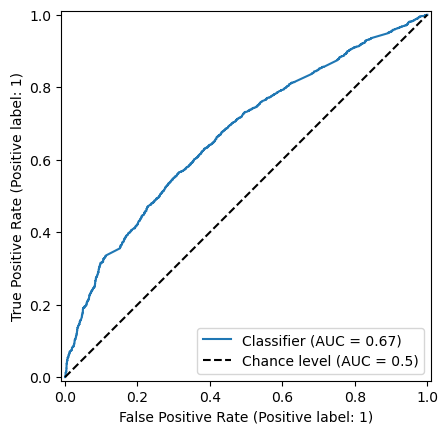

In [37]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_cat_test, y_cat_pred_p_test, plot_chance_level=True);

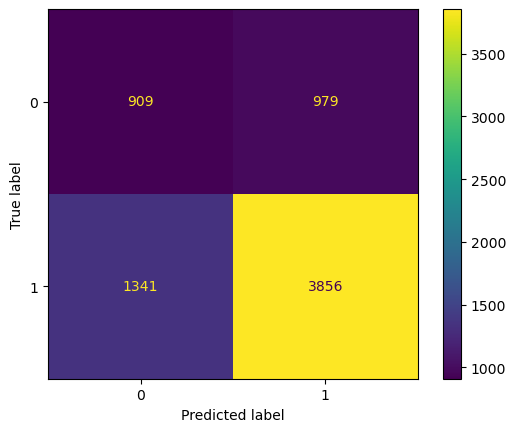

In [38]:
metrics.ConfusionMatrixDisplay.from_predictions(y_cat_test, y_cat_pred_test)

First, the ROC AUC gives us a value of 0.67, showing sensibly better performance than a random classifier. Second, the macro-averaged F1-score is 0.61 and the balanced accuracy is 0.68. The main reason between this reserved performance is the difficulty that has the model to identify defeats. Indeed, the specificity is only 0.46! So if we have a game lost, the model classifies as such only 46% of the time. The recall is a bit better with 0.76. The precision is 0.79. It means that if the model classify a game as a win, there is 4 chances over 5 that the prediction is correct. However, when the model classifies a game as a defeat, it is correct only 41% of the time! This is due to the unbalance between the number of wins and defeats among the samples as mentioned previously.



These results can be explain by a lack of data on players to developp a better model, i.e. more factors would be needed to fully understand what makes a player win, such as their age, their origin, their education level, etc. The model still identify quite well the games that will be won.

In summary, some particular categories do have an influence on the probability of win. The influence of shortest path is rather small, whereas the one from the number of links to the target is rather important. 